#### Import Libs

In [91]:
# import libs
import numpy as np
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import pandas as pd 
from pyproj import CRS
import constant as c
from shapely.wkt import loads
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings; warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier

In [92]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]

In [93]:
# Setting COLS
SIM_CAL_COLS = c.SIM_CAL_COLS
STANDARDIZE_COLS = c.STANDARDIZE_COLS
PP_COLS = c.PP_COLS
BS_COLS = c.BS_COLS
BD_COLS = c.BD_COLS

VAR_COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'pp_drr', # X3
    'bs_ebit', # X4
    'bs_gas', # X5
    'bs_elct', # X6
    'bd_platarea', # X7
    'bd_archarea', # X8
    'bd_totarea', # X9
    'bd_totflrcnt', # X10
    'bd_elvtent', # X11
    'bd_height', # X12
    'bd_vintage', # X13
    ]

TARGET_COL = ['bd_ilp'] # y is individual land price

#### Experiment Settings

In [83]:
YEAR    = 2020
CBD_NM  = "gbd"
TOP_ILP = False

#### Get Important Features

2022_ybd_TOP_ILP:False
DATA_LEN:648
2022_ybd_TOP_ILP:False
['bs_ebit', 'bs_elct', 'bd_height', 'bd_vintage', 'pp_od', 'pp_pop']


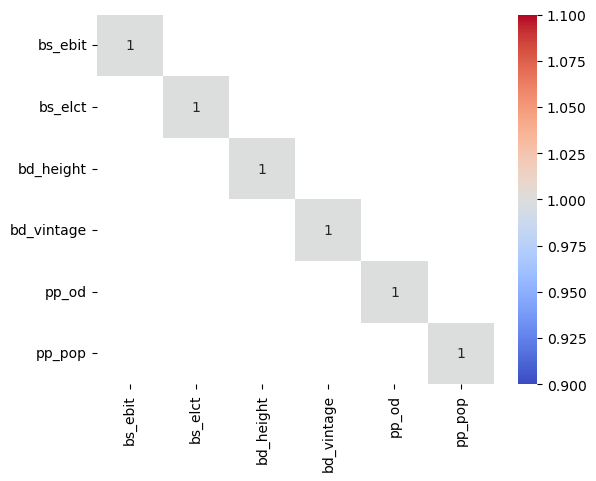

,col,importance,sort
3,bs_ebit,0.685303,bs
11,bd_height,0.068163,bd
12,bd_vintage,0.049146,bd
1,pp_od,0.042073,pp
8,bd_totarea,0.031146,bd
5,bs_elct,0.024624,bs
0,pp_pop,0.019873,pp
4,bs_gas,0.018390,bs
7,bd_archarea,0.017196,bd
10,bd_elvtent,0.015104,bd


In [84]:
df_nm = f'gdf_{YEAR}_{CBD_NM}'


gdf = gpd.GeoDataFrame(locals()[df_nm], geometry='geometry_grids')
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf = gdf.dropna() # drop any data have null value

# and normailze
# Initialize the StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the data
scaler.fit(gdf[STANDARDIZE_COLS])
# Transform the data using the scaler
normalized_data = scaler.transform(gdf[STANDARDIZE_COLS])
gdf_normalized = gdf.copy()
gdf_normalized[STANDARDIZE_COLS] = normalized_data

if TOP_ILP:
    threshold = gdf_normalized['bd_ilp'].quantile(0.75)
    # Select the rows where 'bd_ilp' is in the top 25%
    gdf_normalized = gdf_normalized[gdf_normalized['bd_ilp'] >= threshold]

print(f'{YEAR}_{CBD_NM}_TOP_ILP:{TOP_ILP}\nDATA_LEN:{len(gdf_normalized)}')

# Assuming df is your DataFrame and target is the column you're predicting
X = gdf_normalized[VAR_COLS]
y = gdf_normalized[TARGET_COL]

# Create and fit the model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

# Print feature importances(fi)
importances = model.feature_importances_
fi_df = pd.DataFrame({'col': X.columns, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)
print(f'{YEAR}_{CBD_NM}_TOP_ILP:{TOP_ILP}')
fi_df['sort'] = fi_df['col'].str[:2]
bs_sel_cols = list(fi_df[fi_df['sort'] == 'bs'][:2].col)
bd_sel_cols = list(fi_df[fi_df['sort'] == 'bd'][:2].col)
pp_sel_cols = list(fi_df[fi_df['sort'] == 'pp'][:2].col)
sel_cols = bs_sel_cols + bd_sel_cols + pp_sel_cols # sel(ected)
print(sel_cols)

# Calculate correlation matrix
corr_matrix = gdf_normalized[sel_cols].corr()

# Define a threshold for removing highly correlated variables
threshold = 0.7  # change this to suit your needs

# Create a mask for values above the threshold
mask = abs(corr_matrix) > threshold
sns.heatmap(corr_matrix[mask], annot=True, cmap='coolwarm')
plt.show()
fi_df

#### Execute GWR

In [85]:
# Filling any data point that is nan -> fill by mean value of column

X = gdf_normalized[sel_cols].values
y = gdf_normalized[TARGET_COL].values.reshape((-1,1)) 
print(X.shape)
print(y.shape)

lat = gdf_normalized.centroid.x
lng = gdf_normalized.centroid.y
coords = list(zip(lat,lng))

# calibrate GWR MODEL
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_results = GWR(coords, y, X, gwr_bw).fit()

# append to df
gdf_normalized['gwr_const'] = gwr_results.params[:,0]
for i, col_nm in enumerate(sel_cols):
    gdf_normalized[f'gwr_{col_nm}'] = gwr_results.params[:,i+1]
gdf_normalized['gwr_r2'] = gwr_results.localR2

print(f'{YEAR}_{CBD_NM}_TOP_ILP:{TOP_ILP}')
print(f"SELECTED COLS: {sel_cols}")
# https://mgwr.readthedocs.io/en/latest/_modules/mgwr/gwr.html#GWRResults.summary
gwr_results.summary()

(648, 6)
(648, 1)
2022_ybd_TOP_ILP:False
SELECTED COLS: ['bs_ebit', 'bs_elct', 'bd_height', 'bd_vintage', 'pp_od', 'pp_pop']
Model type                                                         Gaussian
Number of observations:                                                 648
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            213.791
Log-likelihood:                                                    -560.192
AIC:                                                               1134.383
AICc:                                                              1136.609
BIC:                                                              -3935.973
R2:                                                                   0.670
Adj. R2:                                                              0.667

Variable   

In [86]:
# gdf_normalized[['geometry_grids', 'bdnm', 'gwr_r2', 'pp_drr']].explore(column = 'gwr_r2', cmap = 'coolwarm') #, width = 700, height = 500)

In [87]:
result_fpath = f"../asset/experiment/gwr/{CBD_NM}_{YEAR}.csv"
gdf_normalized.to_csv(result_fpath, index = False)